# Part 5: Run Mandelbrot Set calculation concurrently

In [1]:
# NumPy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

In [2]:
%%writefile mandelbrot_numpy.py
import numpy as np

def mandelbrot_numpy(x, y):
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int8)
    z = c
    for i in range(20):
        z = z**2 + c                                 # applying z → z² + c
        diverged = z.real**2 + z.imag**2 > 4         # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == 20)   # some are already done
        fractal[diverging_now] = i                   # just set the new ones
        z[diverged] = 2                              # clamp diverged at 2
    return fractal

Overwriting mandelbrot_numpy.py


In [3]:
from mandelbrot_numpy import mandelbrot_numpy

width, height = 5_000, 5_000
y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]

# calculate the mandelbrot set
mandelbrot_set = mandelbrot_numpy(x, y)

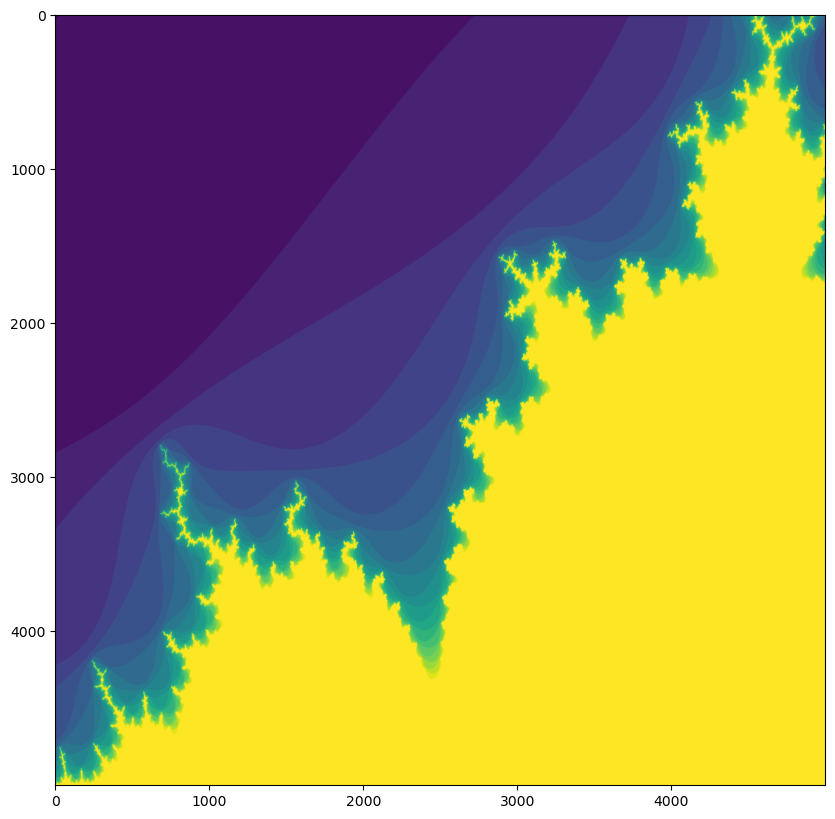

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(mandelbrot_set)

That works, but takes already ~5s... uh oh, that's too long!

### Task: Try using parallelization methods to run this faster!

Tipp: chunk the 2d image into smaller patches that can run in parallel.

In [5]:
%%writefile mandelbrot_numpy_multiprocessing.py
import numpy as np
from mandelbrot_numpy import mandelbrot_numpy

# remember the patch position ij
def task(x, y, ij):
    return mandelbrot_numpy(x, y), ij

Overwriting mandelbrot_numpy_multiprocessing.py


## Solution: multi-processing

In [6]:
import concurrent.futures
from mandelbrot_numpy_multiprocessing import task


width, height = 5_000, 5_000
y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]


chunk_size = 1_000
xs = [x[:, i*chunk_size:(i+1)*chunk_size] for i in range(x.size//chunk_size)]
ys = [y[i*chunk_size:(i+1)*chunk_size, :] for i in range(y.size//chunk_size)]


patches = []
for i, x_chunk in enumerate(xs):
    for j, y_chunk in enumerate(ys):
        patches.append((x_chunk, y_chunk, (i, j)))


# process patches in parallel
n_tasks = len(patches)

with concurrent.futures.ProcessPoolExecutor(max_workers=n_tasks) as executor:
    futures = [executor.submit(task, *patch) for patch in patches]


# collect patches
out = {}
for future in concurrent.futures.as_completed(futures):
    mb, ij = future.result()
    out[ij] = mb

del x, y

# reconstruct full image from patches
full_image = np.empty((width, height), dtype=np.int8)
for (i, j), patch in out.items():
    x_slice = slice(i*chunk_size, (i+1)*chunk_size)
    y_slice = slice(j*chunk_size, (j+1)*chunk_size)
    full_image[y_slice, x_slice] = patch


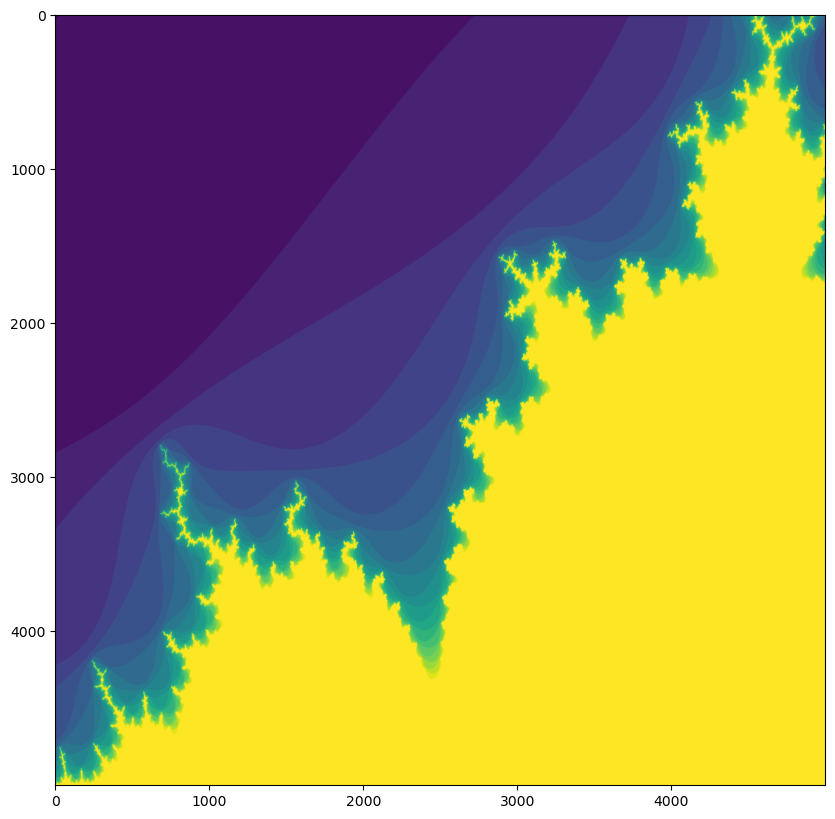

In [7]:
# show the full image
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(full_image)

## Solution: multi-threading

In [8]:
import concurrent.futures
from mandelbrot_numpy_multiprocessing import task


width, height = 5_000, 5_000
y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]


chunk_size = 1_000
xs = [x[:, i*chunk_size:(i+1)*chunk_size] for i in range(x.size//chunk_size)]
ys = [y[i*chunk_size:(i+1)*chunk_size, :] for i in range(y.size//chunk_size)]


patches = []
for i, x_chunk in enumerate(xs):
    for j, y_chunk in enumerate(ys):
        patches.append((x_chunk, y_chunk, (i, j)))


# process patches in parallel
n_tasks = len(patches)

with concurrent.futures.ThreadPoolExecutor(max_workers=n_tasks) as executor:
    futures = [executor.submit(task, *patch) for patch in patches]


# collect patches
out = {}
for future in concurrent.futures.as_completed(futures):
    mb, ij = future.result()
    out[ij] = mb

del x, y

# reconstruct full image from patches
full_image = np.empty((width, height), dtype=np.int8)
for (i, j), patch in out.items():
    x_slice = slice(i*chunk_size, (i+1)*chunk_size)
    y_slice = slice(j*chunk_size, (j+1)*chunk_size)
    full_image[y_slice, x_slice] = patch

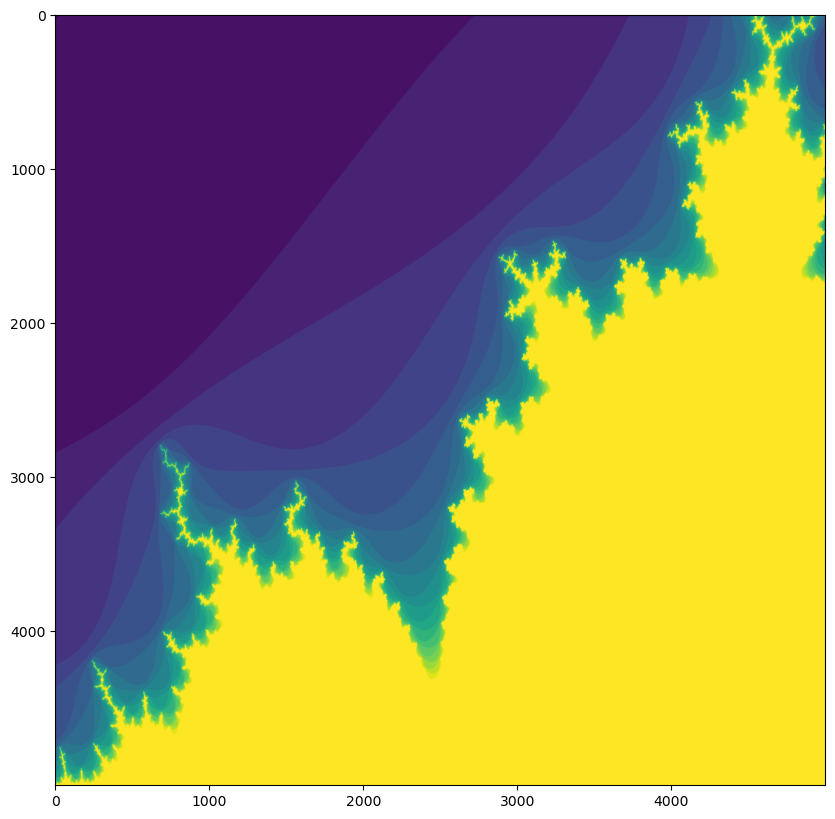

In [9]:
# show the full image
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(full_image)

## Solution: Dask

In [10]:
import dask.distributed

from mandelbrot_numpy_multiprocessing import task


width, height = 5_000, 5_000
y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]


chunk_size = 1_000
xs = [x[:, i*chunk_size:(i+1)*chunk_size] for i in range(x.size//chunk_size)]
ys = [y[i*chunk_size:(i+1)*chunk_size, :] for i in range(y.size//chunk_size)]


patches = []
for i, x_chunk in enumerate(xs):
    for j, y_chunk in enumerate(ys):
        patches.append((x_chunk, y_chunk, (i, j)))


# process patches in parallel
n_tasks = len(patches)

with (
    # multi-threading cluster
    dask.distributed.LocalCluster(n_workers=1, threads_per_worker=n_tasks) as cluster,
    # multi-processing cluster
    # dask.distributed.LocalCluster(n_workers=n_tasks, threads_per_worker=1) as cluster,
    # ---
    # connect to a Dask cluster
    dask.distributed.Client(cluster) as client,
):
    futures = client.map(task, *zip(*patches))

    # collect patches
    out = {}
    for future in dask.distributed.as_completed(futures):
        mb, ij = future.result()
        out[ij] = mb

del x, y

# reconstruct full image from patches
full_image = np.empty((width, height), dtype=np.int8)
for (i, j), patch in out.items():
    x_slice = slice(i*chunk_size, (i+1)*chunk_size)
    y_slice = slice(j*chunk_size, (j+1)*chunk_size)
    full_image[y_slice, x_slice] = patch

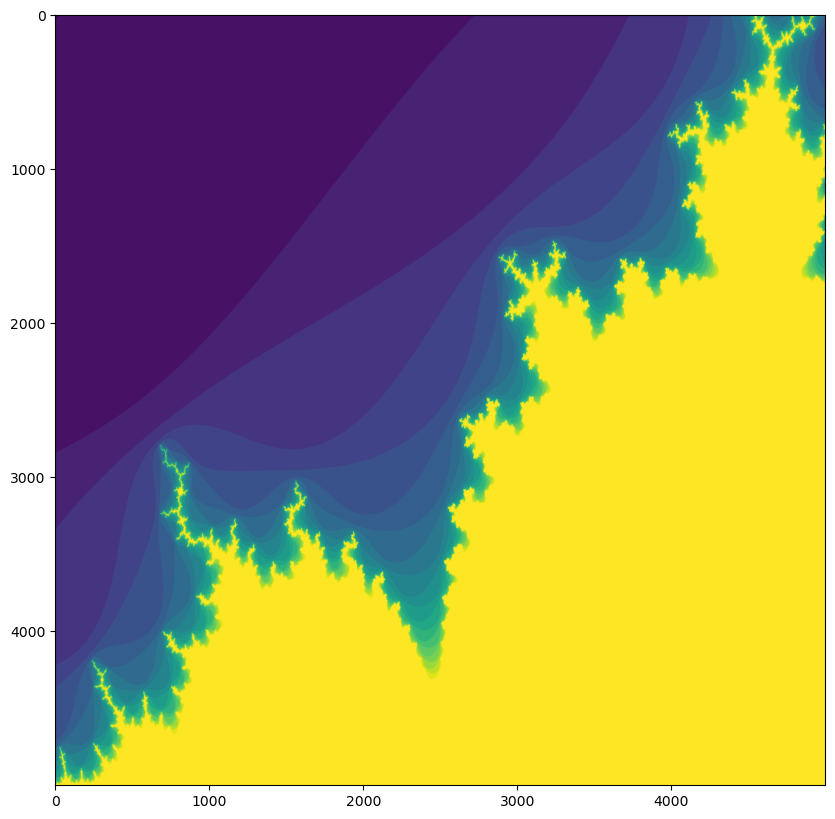

In [11]:
# show the full image
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(full_image)